# Unsupervised Model Evaluation
## 04_unsupervised_model_eval

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 15.10.2025 | Adrienne | Create | Start making visualizations |
| 18.10.2025 | Adrienne | Update | Evaluate word clouds |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN

## Introduction

The unsupervised model did not create the clusters we had hoped as in the end the dataset was just too small. However, wanted to give proof of concept of what part of the evaluation would have entailed.

## Load Data

In [2]:
path = "../data/clean"
patient_df = pd.read_pickle(f"{path}/patient_level_features_med_num.pkl")
X_pca = np.load(f"{path}/X_pca.npy")
df_unsup = pd.read_pickle(f"{path}/df_unsupervised_final.pkl")

In [3]:
# readin hcpcs mapper
mapper_path = "../data/mappers"
hcpcs_mapper = pd.read_pickle(f"{mapper_path}/hcpcs.pkl")
drg_mapper = pd.read_pickle(f"{mapper_path}/drg.pkl")
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

In [70]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        title = "K-Means Clustering Results"
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        title = "Guassian Clustering Results"
        centers = model.means_

            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % (i + 1), 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title(title)
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [4]:
# merge on cluster
df_eval = pd.concat([patient_df, df_unsup], axis = 1)

In [5]:
df_eval.head()

,patient_medicare_number,gender,age,number_of_claims,preventative_care_ind,combined_hcpcs_ls,combined_diagnosis_ls,combined_principal_diagnosis_ls,drg_ls,total_value,...,HCPCS_level_2,HCPCS_level_1,Outpatient_PPS,National_Codes_Established_for_State_Medicaid_Agencies,Temporary_National_Codes_(Non-Medicare),Temporary_Codes,Alcohol_and_Drug_Abuse_Treatment,Evaluation_and_Management_(E/M)_Codes_,Procedures/Professional_Services,cluster
0,1S00E00AA10,0,79.0,18,1,"[G0444, 99221, G0444, G0444, G0444, 99221, 992...","[O039, O039, S63509, O039, O039, O039, O039, S...","[O039, O039, B002, B002, B085, O039, S8290X, J...","[001, 001, 001]",149.37,...,0.746346,0.665558,0.0,0.0,0.0,0.0,0.0,0.665558,0.746346,1
1,1S00E00AA16,1,75.0,17,1,"[99241, G0444, 99241, G0444, 99241, G0444, G95...","[E669, E785, E669, E785, E669, E785, E669, E78...","[E785, E785, E785, E785, B085, E785, E785, J01...",[],234.72,...,0.450512,0.892770,0.0,0.0,0.0,0.0,0.0,0.892770,0.450512,1
2,1S00E00AA23,0,77.0,29,1,"[99241, 99241, 99241, G0444, 99241, 99241, 992...","[J329, E785, I10, J329, E785, P292, J329, E785...","[J329, E785, J329, J029, J329, J029, J329, J32...",[],85.55,...,0.344529,0.938776,0.0,0.0,0.0,0.0,0.0,0.938776,0.344529,1
3,1S00E00AA25,0,78.0,24,1,"[G0107, G0444, 99241, G0444, G0444, 99241, G04...","[E669, D649, K635, O039, M810, J329, Z3400, E6...","[Z3400, Z3400, Z3400, J0190, E669, S72009, J01...",[001],21901.40,...,0.517980,0.855392,0.0,0.0,0.0,0.0,0.0,0.855392,0.517980,1
4,1S00E00AA32,1,80.0,19,1,"[G0444, 99241, G0444, G0444, G0444, G9572, 992...","[P292, E669, I2510, P292, J209, E669, I2510, I...","[J209, J209, J329, J0390, I10, J209, J209, J20...",[001],8388.69,...,0.949550,0.313617,0.0,0.0,0.0,0.0,0.0,0.313617,0.949550,1


### Create Word Clouds

In [6]:
# create principal diagnosis list by cluster
grp = df_eval.groupby('cluster')['combined_principal_diagnosis_ls'].apply(list)
grp_df_principal = pd.DataFrame(grp)
grp_df_principal.reset_index(inplace=True)
grp_df_principal

,cluster,combined_principal_diagnosis_ls
0,0,"[[E785, N390, E785, E785, E785, E785, E785, E7..."
1,1,"[[O039, O039, B002, B002, B085, O039, S8290X, ..."
2,2,"[[M810, M810, M810, M810, M810, M810, M810, M8..."
3,3,"[[J209, S93409, J0190, J0190, F0280, B9789, B9..."
4,4,"[[C50929, C50919, J45909, J45909, C50929, C509..."
5,5,"[[Z3480, Z3480, J0190, J0190, J0190, J0190, J0..."
6,6,"[[I639, B002, B002, J0190, B9789, B9789, B9789..."
7,7,"[[M179, H6690, J329, J329, J329, J329, J329, J..."


In [7]:
# create unique principal diagnosis list by cluster
grp_df_principal['unique_prinicpal_ls'] = grp_df_principal['combined_principal_diagnosis_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [8]:
# look at lengths of unqiue principal diagnosis list
grp_df_principal['principal_diag_ls_len'] = grp_df_principal['unique_prinicpal_ls'].str.len()
vals = grp_df_principal['principal_diag_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
principal_diag_ls_len,
140,1
146,1
109,1
122,1
63,1
41,1
26,1
46,1


In [9]:
grp_df_principal.head()

,cluster,combined_principal_diagnosis_ls,unique_prinicpal_ls,principal_diag_ls_len
0,0,"[[E785, N390, E785, E785, E785, E785, E785, E7...","[E113299, R0902, E1122, M66862, J329, K3533, A...",140
1,1,"[[O039, O039, B002, B002, B085, O039, S8290X, ...","[E113299, E1144, E1122, J329, K3533, E113519, ...",146
2,2,"[[M810, M810, M810, M810, M810, M810, M810, M8...","[E1144, E1122, J329, K3533, A419, S83419, J030...",109
3,3,"[[J209, S93409, J0190, J0190, F0280, B9789, B9...","[E1144, M66862, J329, K3533, S83419, S83209, J...",122
4,4,"[[C50929, C50919, J45909, J45909, C50929, C509...","[Z3480, B349, D649, J0300, S2239X, M810, E785,...",63


In [10]:
# create drg list by cluster
grp = df_eval.groupby('cluster')['drg_ls'].apply(list)
grp_df = pd.DataFrame(grp)
grp_df.reset_index(inplace=True)
grp_df

,cluster,drg_ls
0,0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9..."
1,1,"[[001, 001, 001], [], [], [001], [001], [], [0..."
2,2,"[[975], [], [922, 923, 012, 159, 923, 950, 949..."
3,3,"[[001], [003, 003, 003, 003, 003, 003, 003, 00..."
4,4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,..."
5,5,"[[001], [964, 444], [976], [446], [204, 203, 9..."
6,6,"[[066, 582, 598], [152, 599, 597, 597, 583, 58..."
7,7,"[[001, 003, 001, 001], [003], [], [001], [], [..."


In [11]:
# create unique drg list by cluster
grp_df['unique_drg_ls'] = grp_df['drg_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [12]:
# look at length of drg list
grp_df['unique_drg_ls_len'] = grp_df['unique_drg_ls'].str.len()
vals = grp_df['unique_drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
unique_drg_ls_len,
124,1
134,1
60,1
107,1
64,1
29,1
16,1
37,1


In [13]:
grp_df.head(10)

,cluster,drg_ls,unique_drg_ls,unique_drg_ls_len
0,0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9...","[194, 375, 561, 779, 682, 918, 605, 641, 598, ...",124
1,1,"[[001, 001, 001], [], [], [001], [001], [], [0...","[375, 177, 561, 779, 001, 205, 918, 605, 023, ...",134
2,2,"[[975], [], [922, 923, 012, 159, 923, 950, 949...","[008, 375, 819, 184, 305, 561, 202, 779, 791, ...",60
3,3,"[[001], [003, 003, 003, 003, 003, 003, 003, 00...","[194, 375, 177, 561, 779, 001, 918, 605, 283, ...",107
4,4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,...","[818, 819, 831, 305, 561, 791, 583, 779, 374, ...",64
5,5,"[[001], [964, 444], [976], [446], [204, 203, 9...","[202, 779, 001, 205, 964, 153, 917, 637, 974, ...",29
6,6,"[[066, 582, 598], [152, 599, 597, 597, 583, 58...","[394, 812, 641, 582, 561, 153, 583, 779, 598, ...",16
7,7,"[[001, 003, 001, 001], [003], [], [001], [], [...","[008, 639, 102, 791, 103, 001, 793, 918, 923, ...",37


In [14]:
grp_df_cloud = grp_df.copy()

Some descritpions are missing for some of the codes, but as this is not going to be a final visualization in the analysis but an example, will skip fixing

Word Cloud using MDC Descriptions

Decided to go with an even more granular level than DRG and am using the MDC description

In [15]:
# create work cloud column of MDC descriptions

# iterate through dataset rows
for index, row in grp_df_cloud.iterrows():
    print(index)
    #print(row['principal_unq'])
    # check there there is a drg
    if len(row['unique_drg_ls']) > 1:
        row_ls = []
        for code in row['unique_drg_ls']:
            #print(code)
            # add drg descriptiojn to list
            if drg_mapper['DRG'].isin([code]).any():
                ind = drg_mapper[drg_mapper['DRG'].str.contains(code)].index[0].item()
                #print(ind)
                text = drg_mapper.loc[ind, 'MDC_description']
                #print(f"text {text}")
                # quickly remove some text
                if type(text) == str:
                    text = text.replace('DISEASES & DISORDERS OF ', '')
                    text = text.replace('DISEASES', '')
                    text = text.replace('DISORDERS', '')
                    text = text.replace('THE ', '')
                    text = text.replace('SYSTEM', '')
                    text = text.replace("'", '')
                    #print(text)
                # skip if float indicating NaN
                if type(text) == float:
                    continue
                    #print(f"text nan {text}") 

                row_ls = row_ls + [text]
        print(row_ls)
        grp_df_cloud.at[index, 'word_cloud'] = str(set(row_ls))

0
['RESPIRATORY ', 'DIGESTIVE ', 'MUSCULOSKELETAL  & CONN TISSUE', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'KIDNEY & URINARY TRACT', 'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'EAR, NOSE, MOUTH & THROAT', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'EAR, NOSE, MOUTH & THROAT', 'MUSCULOSKELETAL  & CONN TISSUE', 'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'NERVOUS ', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'NERVOUS ', 'EYE', 'MENTAL  & ', 'MUSCULOSKELETAL  & CONN TISSUE', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'NERVOUS ', 'MUSCULOSKELETAL  & CONN TISSUE', 'RESPIRATORY ', 'DIGESTIVE ', 'MUSCULOSKELETAL  & CONN TISSUE', 'NERVOUS ',

In [16]:
# look at word cloud lengths
for cloud in grp_df_cloud['word_cloud']:
    print(len(cloud.split(',')))

29
28
25
28
25
21
16
21


In [17]:
# quick sense of the words in the word cloud
for group in grp_df_cloud['word_cloud']:
    print(group)

{'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'KIDNEY & URINARY TRACT', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'MENTAL  & ', 'EYE', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'MUSCULOSKELETAL  & CONN TISSUE', 'NEWBORNS & OTHER NEONATES WITH CONDTN ORIG IN PERINATAL PERIOD', 'HUMAN IMMUNODEFICIENCY VIRUS INFECTIONS', 'CIRCULATORY ', 'BLOOD, BLOOD FORMING ORGANS, IMMUNOLOG DISORD', 'NERVOUS ', 'EAR, NOSE, MOUTH & THROAT', 'DIGESTIVE ', 'RESPIRATORY ', 'HEPATOBILIARY  & PANCREAS', 'FACTORS INFLUENCING HLTH STAT & OTHR CONTACTS WITH HLTH SERVCS', 'MULTIPLE SIGNIFICANT TRAUMA'}
{'INJURIES, POISONINGS & TOXIC EFFECTS OF DRUGS', 'KIDNEY & URINARY TRACT', 'ENDOCRINE, NUTRITIONAL & METABOLIC  & ', 'SKIN, SUBCUTANEOUS TISSUE & BREAST', 'INFECTIOUS & PARASITIC , IC OR UNSPECIFIED SITES', 'MENTAL  & ', 'EYE', 'PREGNANCY, CHILDBIRTH & PUERPERIUM', 'MUSCULOSKELETAL  & CONN TISSUE', 'NEWBORNS & OTHER NEONATES 

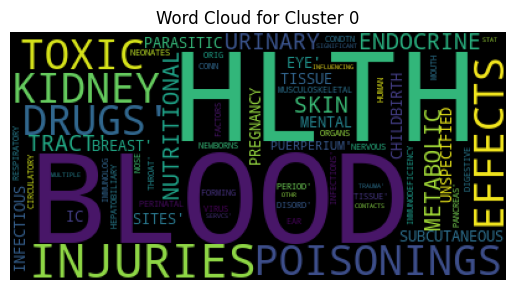

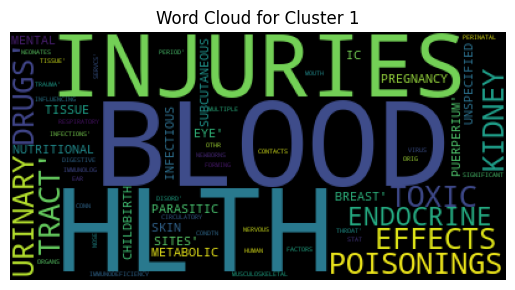

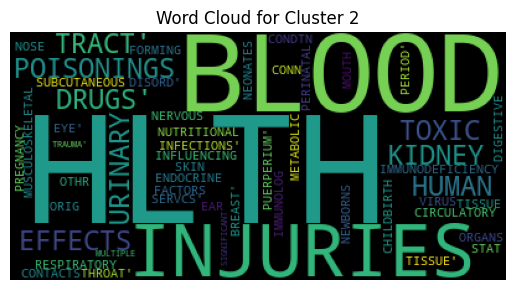

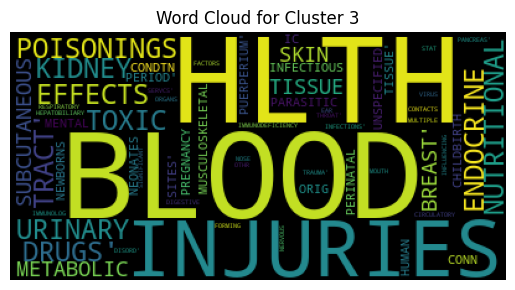

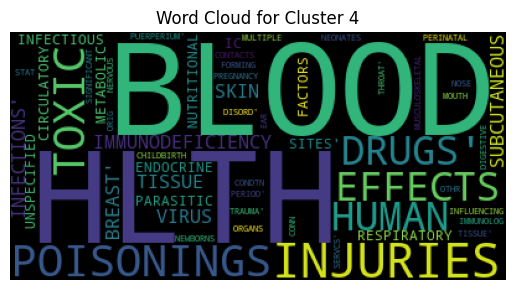

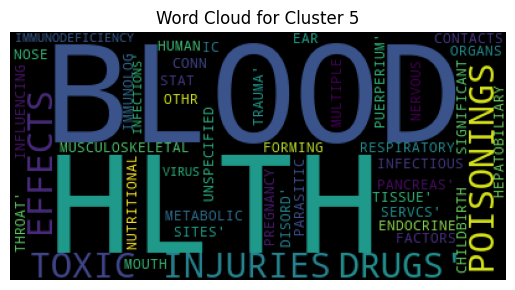

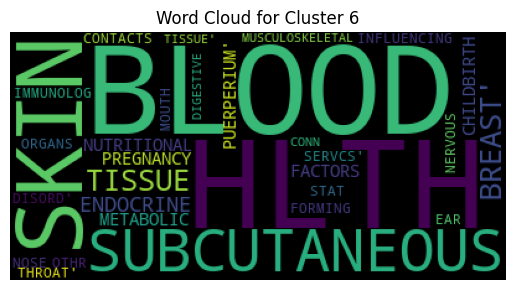

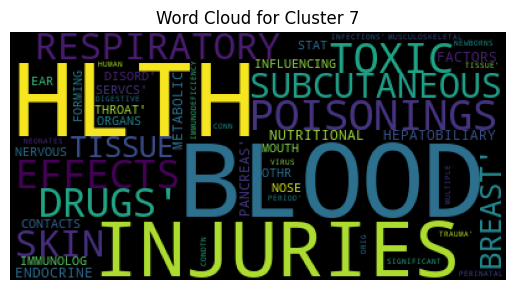

In [18]:
n_clusters = 8
for cluster in range(0,n_clusters):
    df_cluster = grp_df_cloud[grp_df_cloud['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)
    plt.title(f"Word Cloud for Cluster {cluster}")
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

Word Cloud using Principal Diagnosis ICD-10 Code

In [19]:
# create word cloud column of all prinicpal diagnosis descriptions

# iterate through rows
for index, row in grp_df_principal.iterrows():
    #print(row['principal_unq'])
    # check that there is a code
    if len(row['unique_prinicpal_ls']) > 1:
        row_ls = []
        for code in row['unique_prinicpal_ls']:
            #print(code)
            # add ICD-10 description
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split(' ')[0:4]
                #print(f"text {text}") 

            row_ls = row_ls + text
        row_ls = [ word for word in row_ls if word.strip(",'") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        #print(row_ls)
        grp_df_principal.at[index, 'word_cloud'] = str(set(row_ls))
        
    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
            text = [ word for word in text if word.strip(",'") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        
            print(f"text {text}")
            grp_df_principal.at[index, 'word_cloud'] = str(set(text))

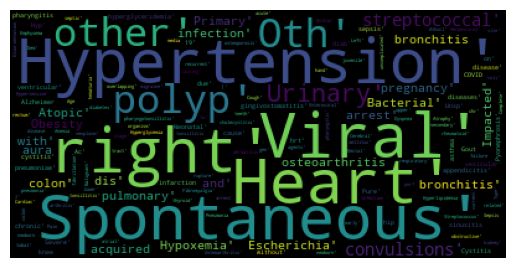

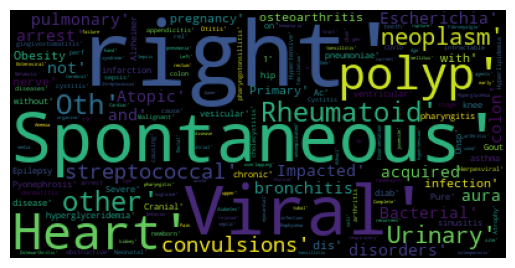

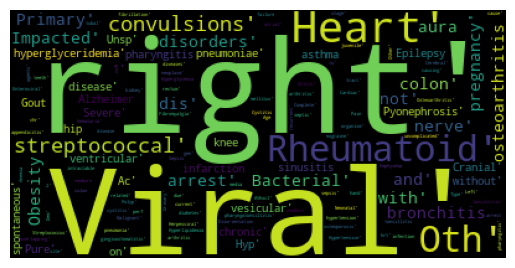

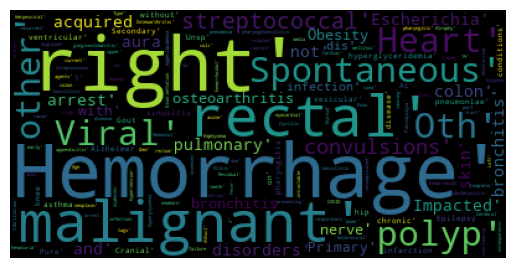

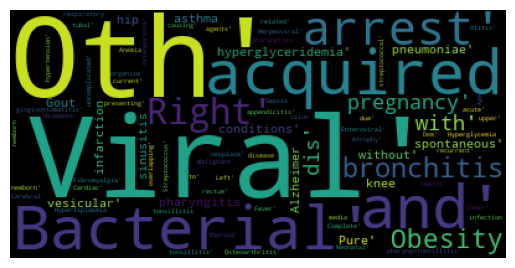

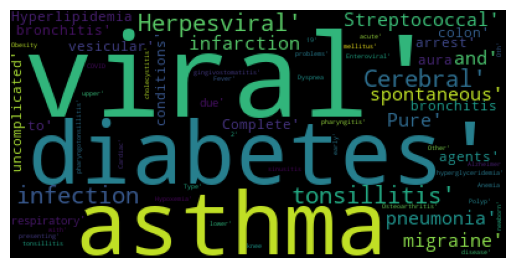

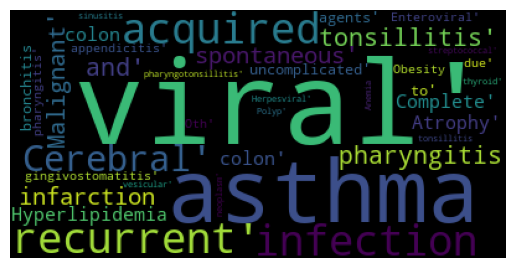

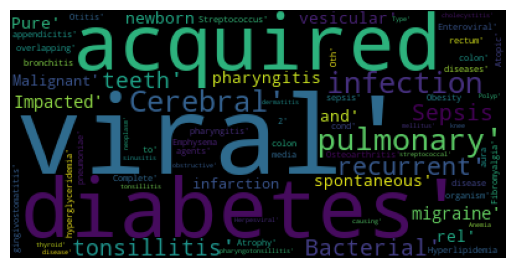

In [20]:
n_clusters = 8
for cluster in range(0,n_clusters):
    df_cluster =grp_df_principal[grp_df_principal['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    diag_cloud = diag_cloud.strip(" '")
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()